# Mach-Zehnder Interferometer as Hadamard gate
This notebook uses qiskit to describe the outcome of the Single Photon Mach-Zehnder experiment as a Hadamard gate and a measurement.
It serves as a simple example how to describe Quantum Mechanical experiments as a circuit of quantum gates.

### Libraries
For the first simulation we use the QasmSimulator:

> "The QasmSimulator backend is designed to mimic an actual device. It executes a Qiskit QuantumCircuit and returns a count dictionary containing the final values of any classical registers in the circuit. 
The circuit may contain gates measure, reset, conditionals, and other advanced simulator options." (https://sooluthomas.github.io/testTranslation/aer/simulate_experiments.html)

In [6]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, qasm3
from qiskit_aer import QasmSimulator, AerSimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram
pi = np.pi

### Mach-Zehnder interferometer
(https://en.wikipedia.org/wiki/Mach–Zehnder_interferometer)

![MZ](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Mach-Zehnder_interferometer.svg/640px-Mach-Zehnder_interferometer.svg.png)

We can model a photon going through the interferometer by assigning a probability amplitude to each of the two possible paths: "lower" and "upper" (actually, the way we've drawn the interferometer, you should think of this as "lower right" and "upper left", separated by a diagonal line going through the rectangle.)

The quantum state describing the photon is a vector $\psi \in \mathbb{C}^2$ that is a superposition (linear combination) of the "lower" path basis vector
$$
\psi_l = \begin{pmatrix} 
0 \\
1 
\end{pmatrix}
$$

and the "upper" path 

$$
\psi_u = \begin{pmatrix} 1 \\
0 
\end{pmatrix}
$$

that is, $\psi = \alpha \psi_l + \beta \psi_u$ for complex $\alpha,\beta$ such that $|\alpha|^2+|\beta|^2 = 1$.

Both beam splitters are modelled as the unitary matrix 

$$
B = \frac1{\sqrt2}
\begin{pmatrix} 
    1 & i \\ 
    i & 1 
\end{pmatrix}
$$

which means that when a photon meets the beam splitter it will either stay on the same path with a probability amplitude of $1/\sqrt{2}$, or be reflected to the other path with a probability amplitude of $i/\sqrt{2}$. Note that besides splitting the beam, there is a phase shift induced for the reflected beam (the $i/\sqrt{2}$). 

The phase shifter on the upper arm is modelled as the unitary matrix 

$$
P = 
\begin{pmatrix} 
    e^{i\Delta\Phi}  & 0 \\
    0 & 1
\end{pmatrix}
$$

which means that if the photon is on the "upper" path it will gain a relative phase of $\Delta\Phi$, and it will stay unchanged if it is on the lower path.

Let's go through each operator. A photon that enters the interferometer from the left starts in the "upper" state, $\psi_u$. After the first beam splitter, the state becomes:

$$
\begin{aligned}
B \psi_u &=\begin{pmatrix} 1/\sqrt{2} & i/\sqrt{2} \\ i/\sqrt{2} & 1/\sqrt{2}\end{pmatrix} \begin{pmatrix} 1 \\ 0 \end{pmatrix}\\
&= \begin{pmatrix} 1/\sqrt{2} \\ i/\sqrt{2} \end{pmatrix}
\end{aligned}
$$

After the phase shifter:
$$
\begin{aligned}
P B \psi_u &= \begin{pmatrix} e^{i\Delta\Phi} & 0 \\ 0 & 1 \end{pmatrix} \begin{pmatrix} 1/\sqrt{2} \\ i/\sqrt{2} \end{pmatrix} \\
&= \begin{pmatrix} e^{i\Delta\Phi}/\sqrt{2} \\ i/\sqrt{2} \end{pmatrix}
\end{aligned}
$$

And finally, after the second beam splitter:

$$
\begin{aligned}
BPB \psi_u &= \begin{pmatrix} 1/\sqrt{2} & i/\sqrt{2} \\ i/\sqrt{2} & 1/\sqrt{2}\end{pmatrix} \begin{pmatrix} e^{i\Delta\Phi}/\sqrt{2} \\ i/\sqrt{2} \end{pmatrix} \\
&= \frac{1}{2}\begin{pmatrix} e^{i\Delta\Phi}-1 \\ i e^{i\Delta\Phi} + i \end{pmatrix} \\
&= \frac{i}{2} e^{i\Delta\Phi/2} \begin{pmatrix} \sin{\frac{\Delta\Phi}{2}} \\ \cos{\frac{\Delta\Phi}{2}} \end{pmatrix}
\end{aligned}
$$


The probabilities that it will be detected at the right or at the top are given respectively by:

$$ 
\begin{aligned}
p(u) &= |\langle \psi_u| BPB|\psi_u \rangle|^2 = \sin^2 \frac{\Delta \Phi}{2}\\
p(l) &= |\langle \psi_l| BPB|\psi_l \rangle|^2 = \cos^2 \frac{\Delta \Phi}{2}
\end{aligned}
$$

One can therefore use the Mach–Zehnder interferometer to estimate the Phase by estimating these probabilities.

As an exercise, consider another case where we block one path, say the lower path, by placing a concrete block in front of the lower mirror. This "zeros" out the lower component of the state vector in between the two beam splitters. If you calculate these operations, you should find that $p(u)=p(l)=1/2$. This makes sense intuitively: by blocking one path, there is no longer any interference, so we have restored a "classical" sort of behavior with equal probabilities. 


## Hadamard Gate - Model
For our model circuit we can now assume that the photon is in a superposition of the top and bottom path.
The quantum logical gate that constructs a superposition is called the Hadamard gate: (https://en.wikipedia.org/wiki/Quantum_logic_gate#Hadamard_(H)_gate)

![Hadamard matrix](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Hadamard_gate.svg/320px-Hadamard_gate.svg.png)

which can act on a single qubit (in our case the Mach-Zehnder Interferometer).

It maps the basis state $|0\rangle$ to $\frac{|0\rangle + |1\rangle}{\sqrt{2}}$ and  $|1\rangle$ to $\frac{|0\rangle - |1\rangle}{\sqrt{2}}$, which means that a measurement will have equal probabilities to result in 1 or 0 (i.e. creates a superposition).
It represents a rotation of $\pi$ about the axis $(\hat{x}+\hat{z})/\sqrt{2}$ at the Bloch sphere (see plotting the state vector below). 
Equivalently, it is the combination of two rotations,  $\pi$ about the Z-axis, then by $\pi/2$ about the Y-axis: 

$$ 
R_y(\pi/2)R_z(\pi) = iH
$$

It is represented by the Hadamard matrix:

$$H = \frac{1}{\sqrt{2}} 
\begin{bmatrix} 
1 & 1 \\
1 & -1 
\end{bmatrix}
$$

Since $HH^\dagger=H^{\dagger}H=I$ where $I$ is the identity matrix, $H$ is a unitary matrix (like all other quantum logical gates).

### Create Quantum circuit

In [17]:
# Create a Quantum Circuit acting on the q register
circuit = QuantumCircuit(QuantumRegister(1), ClassicalRegister(1))

# Add a H gate on qubit 0
circuit.h(0)
#circuit.z(0)
circuit.p(pi*2, 0)
circuit.h(0)

# Map the quantum measurement to the classical bits
circuit.measure([0], [0])

# Draw the circuit
circuit.draw()

┌───┐┌───────┐┌───┐┌─┐
  q3: ┤ H ├┤ P(2π) ├┤ H ├┤M├
      └───┘└───────┘└───┘└╥┘
c3: 1/════════════════════╩═
                          0

### Simulate the quantum circuit

In [18]:
# Use Aer's qasm_simulator
qasm_simulator = QasmSimulator()

# transpile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
# https://en.wikipedia.org/wiki/Source-to-source_compiler
compiled_circuit = transpile(circuit, qasm_simulator)

In [19]:
# print low level code: open Quantum Assembler
print(qasm3.dumps(compiled_circuit))
#print(compiled_circuit.qasm())

OPENQASM 3.0;
include "stdgates.inc";
bit[1] c3;
qubit[1] q3;
c3[0] = measure q3[0];



In [20]:
# Execute the circuit on the qasm simulator
job = qasm_simulator.run(compiled_circuit, shots=1000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("\nTotal count for 00 and 11 are:",counts)


Total count for 00 and 11 are: {'0': 1000}


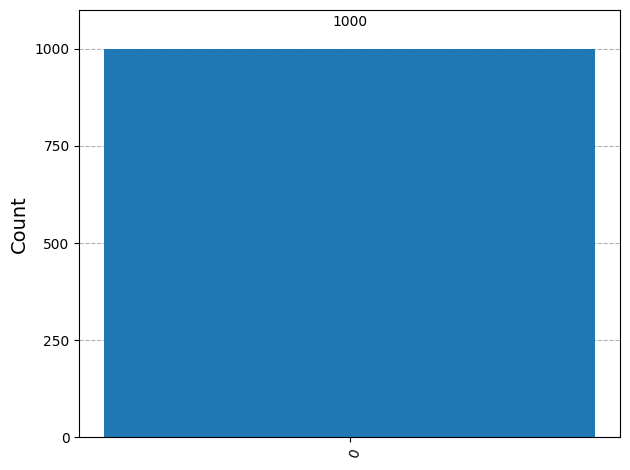

In [21]:
# Plot a histogram
plot_histogram(counts)

## Plot the state vector
To plot the state vector we do not need to (should not) do a measurement.
You can use the QasmSimulator backend and the `SaveStateVector` function, or use another simulator made for this purpose:

'statevector_simulator'

In [22]:
#from qiskit import BasicAer, execute
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

In [23]:
circuit.draw()

┌───┐┌───────┐┌───┐┌─┐
  q3: ┤ H ├┤ P(2π) ├┤ H ├┤M├
      └───┘└───────┘└───┘└╥┘
c3: 1/════════════════════╩═
                          0

Let's redo our circuit, splitting the circuit and the measurement

In [24]:
# Create a Quantum Circuit acting on the q register
qr = QuantumRegister(1)
qc = QuantumCircuit(qr)

# Add a H gate on qubit 0
qc.h(0)
qc.draw()

┌───┐
q4: ┤ H ├
    └───┘

In [25]:
# execute the quantum circuit
#backend = StateVectorSimulator AerSimulator.get_backend('statevector_simulator') # the device to run on
sv_simulator = StatevectorSimulator()
qc = transpile(qc, sv_simulator)
job = sv_simulator.run(qc)
result = job.result()
psi  = result.get_statevector(qc)

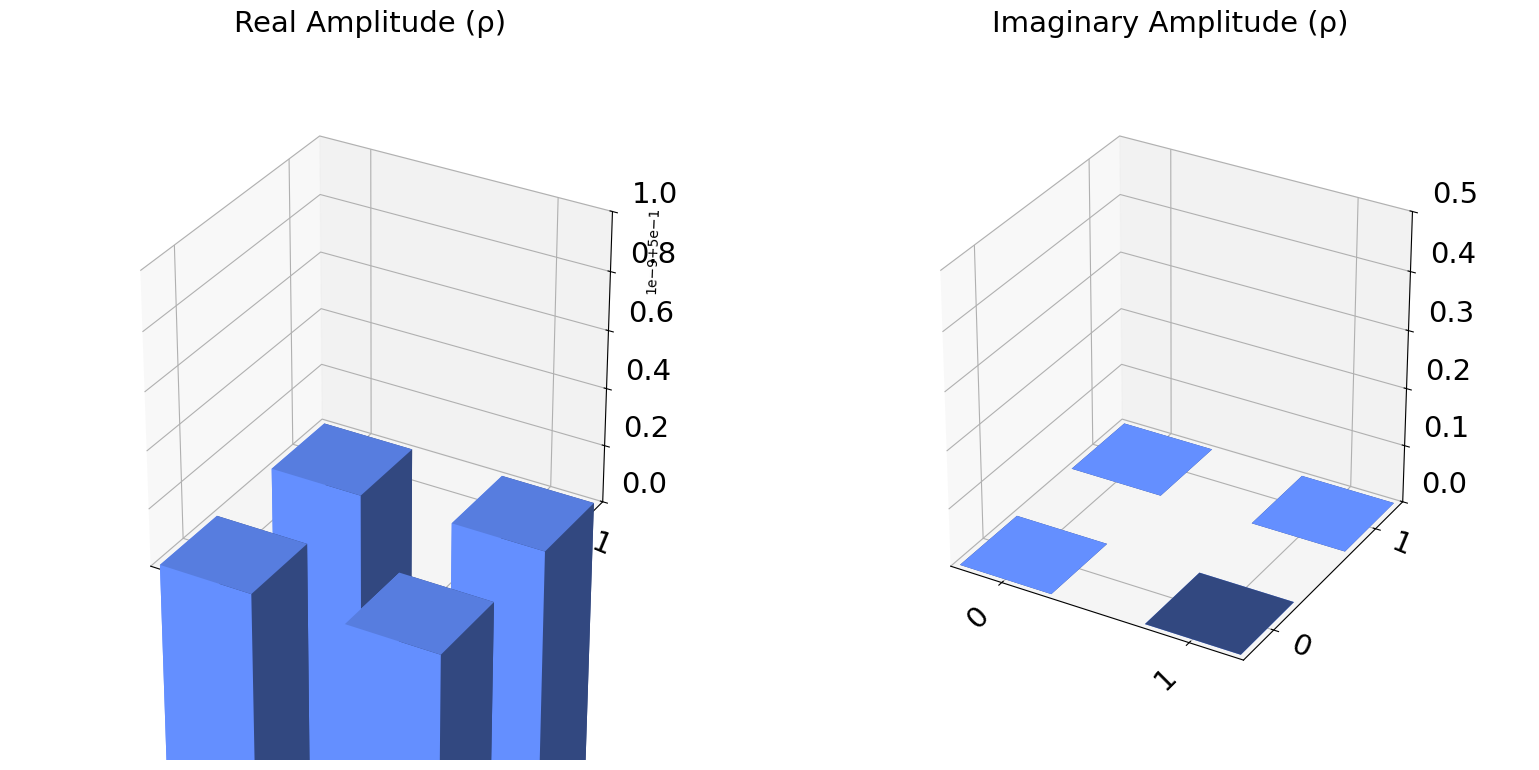

In [26]:
plot_state_city(psi)

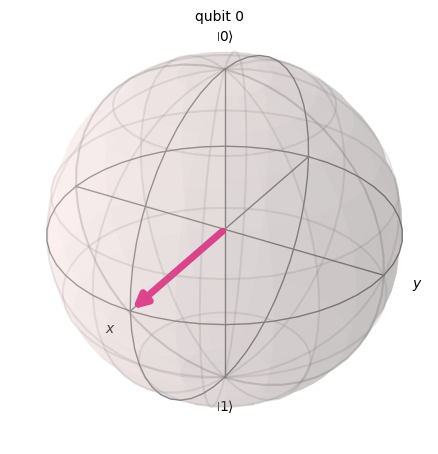

In [27]:
plot_bloch_multivector(psi)

## Combining Quantum Circuits

In [28]:
# measurement circuit
meas = QuantumCircuit(qr, ClassicalRegister(1))
meas.measure(qr,[0])
# Draw the circuit
meas.draw()

┌─┐
  q4: ┤M├
      └╥┘
c4: 1/═╩═
       0

In [29]:
qc_cc = qc.compose(meas)
#circ = qcirc+meas
qc_cc.draw()

┌───┐┌─┐
  q4: ┤ H ├┤M├
      └───┘└╥┘
c4: 1/══════╩═
            0

In [30]:
qc_cc = transpile(qc_cc, qasm_simulator)
job = qasm_simulator.run(qc_cc, shots=1000)
result = job.result()
#result = execute(circ, backend, shots=1000).result()
counts  = result.get_counts(qc_cc)
print(counts)

{'0': 499, '1': 501}


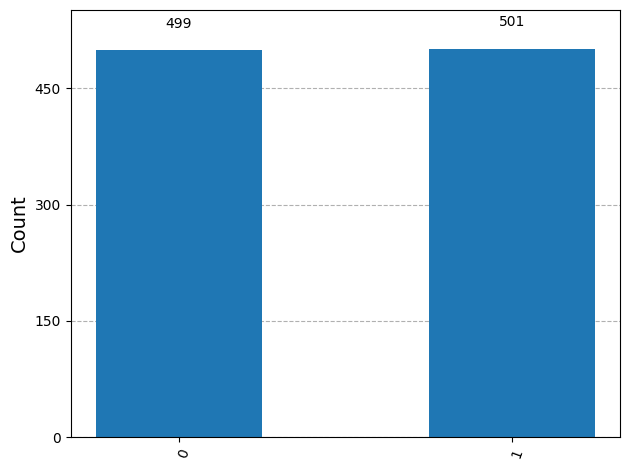

In [31]:
plot_histogram(counts)